# Objective
In this dataset you have 3 different outputs:
    
- No readmission;
- A readmission in less than 30 days (this situation is not good, because maybe your treatment was not appropriate);
- A readmission in more than 30 days (this one is not so good as well the last one, however, the reason could be the state of the patient.

Your task is either to classify a patient-hospital outcome or to cluster them aiming at finding patterns that give a distinct insight.

To do so, we suggest you create a notebook, like Jupyter (if you use python) or a Rmarkdown report (in case you use R) and make it available for us, i.e. github.

### Hint to success in your quest:

Develop and stay clear of the data science process you'll perform over the dataset and highlight important aspects you might consider affordable to discuss over.

https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008#

### Data Set Information:

The dataset represents 10 years (1999-2008) of clinical care at 130 US hospitals and integrated delivery networks. It includes over 50 features representing patient and hospital outcomes. Information was extracted from the database for encounters that satisfied the following criteria.

    *(1) It is an inpatient encounter (a hospital admission).
    *(2) It is a diabetic encounter, that is, one during which any kind of diabetes was entered to the system as a diagnosis.
    *(3) The length of stay was at least 1 day and at most 14 days.
    *(4) Laboratory tests were performed during the encounter.
    *(5) Medications were administered during the encounter.
    
The data contains such attributes as patient number, race, gender, age, admission type, time in hospital, medical specialty of admitting physician, number of lab test performed, HbA1c test result, diagnosis, number of medication, diabetic medications, number of outpatient, inpatient, and emergency visits in the year before the hospitalization, etc.



In [1]:
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt

In [2]:
from pandarallel import pandarallel
pandarallel.initialize()

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

In [3]:
pd.options.display.float_format = '{:,.1f}'.format 

In [7]:
df_diabetic = pd.read_csv('diabetic_data.csv')
df_diabetic.shape

(101766, 50)

### Understanding NaNs

In [8]:
df_diabetic.isnull().sum().sum()

0

In [9]:
df_diabetic.sample(4).T

,58459,68627,83951,28670
encounter_id,165634674,193953012,263686878,93963606
patient_nbr,56356434,100001178,67194522,10222596
race,Caucasian,Caucasian,Caucasian,?
gender,Female,Male,Male,Female
age,[60-70),[80-90),[50-60),[30-40)
weight,?,?,?,?
admission_type_id,1,1,1,2
discharge_disposition_id,1,3,3,1
admission_source_id,7,7,7,1
time_in_hospital,4,4,3,4


### Reformating "?" and "None" for null

In [10]:
df_diabetic = df_diabetic.applymap(lambda x: x.strip() if isinstance(x, str) else x)
df_diabetic = df_diabetic.applymap(lambda x: np.nan if (x=='?') | (x=='None') else x if isinstance(x, str) else x)
df_diabetic.isnull().sum().sort_values(ascending=False).head(10)

weight               98569
max_glu_serum        96420
A1Cresult            84748
medical_specialty    49949
payer_code           40256
race                  2273
diag_3                1423
diag_2                 358
diag_1                  21
gender                   0
dtype: int64

In [11]:
df_diabetic.isnull().sum().sort_values(ascending=False).head(10)/df_diabetic.shape[0]*100

weight              96.9
max_glu_serum       94.7
A1Cresult           83.3
medical_specialty   49.1
payer_code          39.6
race                 2.2
diag_3               1.4
diag_2               0.4
diag_1               0.0
gender               0.0
dtype: float64

### There are 3 columns with near of ~90% of null data

In [12]:
df_diabetic['max_glu_serum'].value_counts()

Norm    2597
>200    1485
>300    1264
Name: max_glu_serum, dtype: int64

In [13]:
df_diabetic['weight'].value_counts()

[75-100)     1336
[50-75)       897
[100-125)     625
[125-150)     145
[25-50)        97
[0-25)         48
[150-175)      35
[175-200)      11
>200            3
Name: weight, dtype: int64

### Generate pandas profiling report to validate variables

In [15]:
do_profiling = True
if do_profiling:
    profile = ProfileReport(df_diabetic, title="Diabetics Profiling Report",
                            explorative=True,
                            correlations={"cramers": {"calculate": False}})
    profile.to_file('diabetic_report.html')

Pandas profiling generates a report HTML with basic information about DB missing values, unique values and so on.

In [16]:
ls

David_Torres.ipynb             diabetic_report.html  model_ohe.parquet
description.pdf                IDs_mapping.csv       tsne_results.parquet
df_diabetic_processed.parquet  logs.log
diabetic_data.csv              mlruns/


### Exploring other data sources

In [17]:
df_IDs = {}
df_IDs['admission_type'] = pd.read_csv('IDs_mapping.csv',nrows=8)
df_IDs['discharge_disposition'] = pd.read_csv('IDs_mapping.csv',nrows=29,skiprows=10)
df_IDs['admission_source'] = pd.read_csv('IDs_mapping.csv',nrows=29,skiprows=42)

In [18]:
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

In [19]:
display_side_by_side(df_IDs['admission_type'],df_IDs['admission_source'],df_IDs['discharge_disposition'])

,admission_type_id,description
0,1,Emergency
1,2,Urgent
2,3,Elective
3,4,Newborn
4,5,Not Available
5,6,NaN
6,7,Trauma Center
7,8,Not Mapped
,admission_source_id,description
0,1,Physician Referral


In [20]:
df_IDs.keys()

dict_keys(['admission_type', 'discharge_disposition', 'admission_source'])

### The following columns will be considered as categories given the previous informations

In [21]:
# numeric to categorical
col_categories=['admission_type_id', 'discharge_disposition_id', 'admission_source_id']
df_diabetic[col_categories] = df_diabetic[col_categories].apply(pd.Categorical)

In [22]:
col_categories=['encounter_id','patient_nbr']
df_diabetic[col_categories] = df_diabetic[col_categories].apply(pd.Categorical)

In [23]:
df_diabetic.describe()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,"101,766.0","101,766.0","101,766.0","101,766.0","101,766.0","101,766.0","101,766.0","101,766.0"
mean,4.4,43.1,1.3,16.0,0.4,0.2,0.6,7.4
std,3.0,19.7,1.7,8.1,1.3,0.9,1.3,1.9
min,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
25%,2.0,31.0,0.0,10.0,0.0,0.0,0.0,6.0
50%,4.0,44.0,1.0,15.0,0.0,0.0,0.0,8.0
75%,6.0,57.0,2.0,20.0,0.0,0.0,1.0,9.0
max,14.0,132.0,6.0,81.0,42.0,76.0,21.0,16.0


In [24]:
df_describe_object =  df_diabetic.describe(include=[object,'category']).T
df_describe_object.T

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,payer_code,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
count,101766,101766,99493,101766,101766,3197,101766,101766,101766,61510,...,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766
unique,101766,71518,5,3,10,9,8,26,17,17,...,1,4,4,2,2,2,2,2,2,3
top,443867222,88785891,Caucasian,Female,[70-80),[75-100),1,1,7,MC,...,No,No,No,No,No,No,No,No,Yes,NO
freq,1,40,76099,54708,26068,1336,53990,60234,57494,32439,...,101766,47383,101060,101753,101765,101764,101765,54755,78363,54864


### With help of the pandas profiling report we can delete and reorganizate some columns. For example for gener column we can delete unknow class due it represents less than 0.1%

In [25]:
# Delete 0.1%
df_diabetic = df_diabetic[df_diabetic['gender'].isin(['Female', 'Male'])]
df_describe_object =  df_diabetic.describe(include=[object,'category']).T

### Some of the categories with less than 4 unique values could be processed into binary variables, and some oridnal categories can be reinterpreted as numeric.

In [26]:
df_describe_object[df_describe_object['unique'].isin([1,2,3,4])]

,count,unique,top,freq
gender,101763,2,Female,54708
max_glu_serum,5346,3,Norm,2597
A1Cresult,17018,3,>8,8216
metformin,101763,4,No,81776
repaglinide,101763,4,No,100224
nateglinide,101763,4,No,101060
chlorpropamide,101763,4,No,101677
glimepiride,101763,4,No,96572
acetohexamide,101763,2,No,101762
glipizide,101763,4,No,89078


In [27]:
df_diabetic['max_glu_serum'] = df_diabetic['max_glu_serum'].replace({'Norm':100,'>200':200,'>300':300})

<ipython-input-27-6e34a4dc4d3b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_diabetic['max_glu_serum'] = df_diabetic['max_glu_serum'].replace({'Norm':100,'>200':200,'>300':300})


In [28]:
df_diabetic['A1Cresult'] = df_diabetic['A1Cresult'].replace({'Norm':4,'>7':7,'>8':8})

<ipython-input-28-f76cc7ca8897>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_diabetic['A1Cresult'] = df_diabetic['A1Cresult'].replace({'Norm':4,'>7':7,'>8':8})


### For medicaments let's create two new columns changes over the dosage and if the person was using the medicament. Also lets create a counter variable for number of medicaments and changes on dosages.

In [29]:
# 'Up','Down' -> 'Yes' (indicates changes on dosage)
# 'Up','Down','Steady' -> 'Yes' (indicates drugs)

cols_med = ['metformin', 'repaglinide',
       'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide',
       'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
       'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide',
       'examide','citoglipton',
       'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone']


df_diabetic['cnt_meds_change']=0
df_diabetic['cnt_meds']=0

for i in cols_med:
    df_diabetic[i+'_change'] = df_diabetic[i].isin(['Up','Down'])*1
    df_diabetic[i] = df_diabetic[i].isin(['Up','Down','Steady'])*1
    
    df_diabetic['cnt_meds_change'] = df_diabetic['cnt_meds'] + df_diabetic[i+'_change']
    df_diabetic['cnt_meds'] = df_diabetic['cnt_meds'] + df_diabetic[i] 

<ipython-input-29-253607db7d0a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_diabetic['cnt_meds_change']=0
<ipython-input-29-253607db7d0a>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_diabetic['cnt_meds']=0
<ipython-input-29-253607db7d0a>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

In [30]:
df_describe_object =  df_diabetic.describe(include=[object,'category']).T
cols_cat_2 = df_describe_object[df_describe_object['unique']==2].index
df_describe_object[df_describe_object['unique']==2]

,count,unique,top,freq
gender,101763,2,Female,54708
change,101763,2,No,54754
diabetesMed,101763,2,Yes,78361


In [31]:
df_diabetic[cols_cat_2].isnull().sum().sum()

0

In [32]:
df_diabetic = pd.concat([
    df_diabetic,
    pd.get_dummies(df_diabetic[cols_cat_2], drop_first=True)
],axis=1).drop(columns=cols_cat_2)

### Age and weight are interpreted as numeric

In [33]:
def interval_to_num(x):
    if isinstance(x, str):
        x_num = re.findall(r'\d+.*-', x)
        if len(x_num) > 0:
            return int(x_num[0][:-1])
        else:
            return int(re.findall(r'>.*\d', x)[0][1:])
    else:
        return np.nan 

In [34]:
display_side_by_side(df_diabetic['age'].value_counts().reset_index(), df_diabetic['weight'].value_counts().reset_index())

,index,age
0,[70-80),26066
1,[60-70),22482
2,[50-60),17256
3,[80-90),17197
4,[40-50),9685
5,[30-40),3775
6,[90-100),2793
7,[20-30),1657
8,[10-20),691
9,[0-10),161


In [35]:
#weigth
interval_to_num('[150-175)')+12.5

162.5

In [36]:
#age
interval_to_num('[0-10)')+5

5

In [37]:
df_diabetic['age'] = df_diabetic['age'].apply(interval_to_num)+5
df_diabetic['weight'] = df_diabetic['weight'].apply(interval_to_num)+12.5

### Delete constant columns

In [38]:
# constant columns
df_diabetic.describe().columns[df_diabetic[df_diabetic.describe().columns].sum()==0]

Index(['examide', 'citoglipton', 'acetohexamide_change', 'tolbutamide_change',
       'troglitazone_change', 'examide_change', 'citoglipton_change',
       'glipizide-metformin_change', 'glimepiride-pioglitazone_change',
       'metformin-rosiglitazone_change', 'metformin-pioglitazone_change'],
      dtype='object')

In [39]:
df_diabetic = df_diabetic.drop(columns=['examide', 'citoglipton', 'acetohexamide_change', 'tolbutamide_change',
       'troglitazone_change', 'examide_change', 'citoglipton_change',
       'glipizide-metformin_change', 'glimepiride-pioglitazone_change',
       'metformin-rosiglitazone_change', 'metformin-pioglitazone_change'])

In [40]:
df_diabetic.describe(include=[object,'category']).T

,count,unique,top,freq
encounter_id,101763,101763,443867222,1
patient_nbr,101763,71515,88785891,40
race,99492,5,Caucasian,76099
admission_type_id,101763,8,1,53988
discharge_disposition_id,101763,26,1,60232
admission_source_id,101763,17,7,57492
payer_code,61508,17,MC,32439
medical_specialty,51816,72,InternalMedicine,14635
diag_1,101742,716,428,6862
diag_2,101405,748,276,6752


In [41]:
df_diabetic[df_diabetic.describe().columns].sum()

age                          6,712,985.0
weight                         275,837.5
time_in_hospital               447,352.0
num_lab_procedures           4,385,569.0
num_procedures                 136,331.0
num_medications              1,630,430.0
number_outpatient               37,588.0
number_emergency                20,133.0
number_inpatient                64,679.0
number_diagnoses               755,351.0
max_glu_serum                  935,900.0
A1Cresult                      112,372.0
metformin                       19,987.0
repaglinide                      1,539.0
nateglinide                        703.0
chlorpropamide                      86.0
glimepiride                      5,191.0
acetohexamide                        1.0
glipizide                       12,685.0
glyburide                       10,650.0
tolbutamide                         23.0
pioglitazone                     7,327.0
rosiglitazone                    6,364.0
acarbose                           308.0
miglitol        

### Finally let's to explore our target value

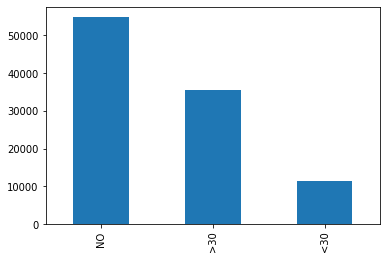

In [42]:
df_diabetic['readmitted'].value_counts().plot(kind='bar')

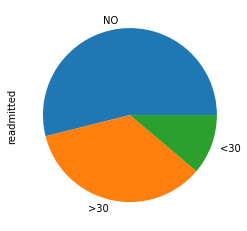

In [43]:
df_diabetic['readmitted'].value_counts().plot.pie()

### The class in genral is very unbalanced but if we consider >30 and <30 as one, the base is some balanced

### As first MVP let's encode some information about the past behaviour of the patients, as number of registries, visits, number of medicaments, number of past readmissions. For this last, let's shift and cumulate the sums.

In [44]:
df_diabetic = df_diabetic.sort_values('encounter_id')

In [45]:
df_diabetic.describe().T

,count,mean,std,min,25%,50%,75%,max
age,"101,763.0",66.0,15.9,5.0,55.0,65.0,75.0,95.0
weight,"3,197.0",86.3,26.1,12.5,62.5,87.5,112.5,212.5
time_in_hospital,"101,763.0",4.4,3.0,1.0,2.0,4.0,6.0,14.0
num_lab_procedures,"101,763.0",43.1,19.7,1.0,31.0,44.0,57.0,132.0
num_procedures,"101,763.0",1.3,1.7,0.0,0.0,1.0,2.0,6.0
num_medications,"101,763.0",16.0,8.1,1.0,10.0,15.0,20.0,81.0
number_outpatient,"101,763.0",0.4,1.3,0.0,0.0,0.0,0.0,42.0
number_emergency,"101,763.0",0.2,0.9,0.0,0.0,0.0,0.0,76.0
number_inpatient,"101,763.0",0.6,1.3,0.0,0.0,0.0,1.0,21.0
number_diagnoses,"101,763.0",7.4,1.9,1.0,6.0,8.0,9.0,16.0


In [46]:
def feature_eng(df_):
    df_temp = pd.DataFrame(index=df_.index, columns=['age_mean', 'n_entry', 'cum_time_in_hospital', 'cum_cnt_meds',
       'cum_cnt_meds_change', 'number_inpatient_log', 'number_outpatient_log',
       'number_emergency_log', 'number_visits', 'number_visits_log',
       'number_inpatient_cumsum', 'number_outpatient_cumsum',
       'number_emergency_cumsum', 'number_visits_cumsum',
       'readmited_times_<30_past', 'readmited_times_>30_past',
       'readmited_times_NO_past', 'readmited_times_<30_past_ratio',
       'readmited_times_>30_past_ratio', 'readmited_times_NO_past_ratio'])

    df_temp['ones'] = 1
    # Store mean afe during all studies
    df_temp['age_mean'] = df_['age'].mean()
    # Number of registries (entries)
    df_temp['n_entry'] = df_temp['ones'].cumsum()

    # Cumualted time on hospital
    df_temp['cum_time_in_hospital'] = df_['time_in_hospital'].cumsum()
    
    # Count of medicaments and change of dosage
    df_temp['cum_cnt_meds'] = df_['cnt_meds'].cumsum()
    df_temp['cum_cnt_meds_change'] = df_['cnt_meds_change'].cumsum()

    # From pandas profiling histograms we can try to normalizate some skewed distrbutions
    df_temp['number_inpatient_log'] = np.log(df_['number_inpatient']+1)
    df_temp['number_outpatient_log'] = np.log(df_['number_outpatient']+1)
    df_temp['number_emergency_log'] = np.log(df_['number_emergency']+1)

    # Total of visits
    df_temp['number_visits'] = df_['number_inpatient']  + df_['number_outpatient'] + df_['number_emergency']
    df_temp['number_visits_log'] = np.log(df_temp['number_visits']+1)

    # Cumulated visits
    df_temp['number_inpatient_cumsum'] = df_temp['number_inpatient_log'].cumsum()
    df_temp['number_outpatient_cumsum'] = df_temp['number_outpatient_log'].cumsum()
    df_temp['number_emergency_cumsum'] = df_temp['number_emergency_log'].cumsum()
    df_temp['number_visits_cumsum'] = df_temp['number_visits_log'].cumsum()

    # readmited counters, value are shifted to avoid overfitting
    df_temp['readmited_times_<30_past'] = (df_['readmitted'].shift() == '<30').cumsum()
    df_temp['readmited_times_>30_past'] = (df_['readmitted'].shift() == '>30').cumsum()
    df_temp['readmited_times_NO_past'] = (df_['readmitted'].shift() == 'NO').cumsum()

    # ratio of readmited counters by registry
    df_temp['readmited_times_<30_past_ratio'] = df_temp['readmited_times_<30_past'] /df_temp['n_entry']
    df_temp['readmited_times_>30_past_ratio'] = df_temp['readmited_times_>30_past'] /df_temp['n_entry']   
    df_temp['readmited_times_NO_past_ratio'] = df_temp['readmited_times_NO_past'] /df_temp['n_entry']   

    return df_temp.drop(columns='ones')

### Parallel apply is better to create the new features

In [47]:
df_new_feng=df_diabetic.groupby(['patient_nbr']).parallel_apply(feature_eng)

In [48]:
ls

David_Torres.ipynb             diabetic_report.html  model_ohe.parquet
description.pdf                IDs_mapping.csv       tsne_results.parquet
df_diabetic_processed.parquet  logs.log
diabetic_data.csv              mlruns/


In [49]:
df_diabetic_processed = pd.concat([df_diabetic,df_new_feng],axis=1)

In [50]:
pd.set_option('display.max_rows', 100)
df_ =df_diabetic_processed[
    df_diabetic_processed['patient_nbr']==(df_diabetic_processed[df_diabetic_processed['n_entry']>1]['patient_nbr'].sample(1).values[0])
]
df_.T

,5668,8574
encounter_id,29167980,38562012
patient_nbr,36179685,36179685
race,Caucasian,Caucasian
age,65,65
weight,NaN,NaN
admission_type_id,6,6
discharge_disposition_id,1,1
admission_source_id,17,17
time_in_hospital,7,6
payer_code,NaN,NaN


In [62]:
num_cols = df_diabetic_processed.describe().columns
df_diabetic_processed.describe()

,age,weight,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,...,number_inpatient_cumsum,number_outpatient_cumsum,number_emergency_cumsum,number_visits_cumsum,readmited_times_<30_past,readmited_times_>30_past,readmited_times_NO_past,readmited_times_<30_past_ratio,readmited_times_>30_past_ratio,readmited_times_NO_past_ratio
count,"101,763.0","3,197.0","101,763.0","101,763.0","101,763.0","101,763.0","101,763.0","101,763.0","101,763.0","101,763.0",...,"101,763.0","101,763.0","101,763.0","101,763.0","101,763.0","101,763.0","101,763.0","101,763.0","101,763.0","101,763.0"
mean,66.0,86.3,4.4,43.1,1.3,16.0,0.4,0.2,0.6,7.4,...,0.7,0.3,0.3,1.1,0.2,0.4,0.0,0.0,0.1,0.0
std,15.9,26.1,3.0,19.7,1.7,8.1,1.3,0.9,1.3,1.9,...,2.4,1.1,1.4,2.9,0.7,1.0,0.1,0.1,0.2,0.0
min,5.0,12.5,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,55.0,62.5,2.0,31.0,0.0,10.0,0.0,0.0,0.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,65.0,87.5,4.0,44.0,1.0,15.0,0.0,0.0,0.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,75.0,112.5,6.0,57.0,2.0,20.0,0.0,0.0,1.0,9.0,...,0.7,0.0,0.0,1.1,0.0,0.0,0.0,0.0,0.0,0.0
max,95.0,212.5,14.0,132.0,6.0,81.0,42.0,76.0,21.0,16.0,...,91.1,30.8,47.2,103.5,22.0,17.0,2.0,0.9,0.9,0.5


In [61]:
cat_cols = df_diabetic_processed.describe(include=[object,'category']).columns
df_diabetic_processed.describe(include=[object,'category'])

,encounter_id,patient_nbr,race,admission_type_id,discharge_disposition_id,admission_source_id,payer_code,medical_specialty,diag_1,diag_2,diag_3,readmitted
count,101763,101763,99492,101763,101763,101763,61508,51816,101742,101405,100340,101763
unique,101763,71515,5,8,26,17,17,72,716,748,789,3
top,443867222,88785891,Caucasian,1,1,7,MC,InternalMedicine,428,276,250,NO
freq,1,40,76099,53988,60232,57492,32439,14635,6862,6752,11555,54861


In [57]:
df_diabetic_processed.dtypes

encounter_id                      category
patient_nbr                       category
race                                object
age                                  int64
weight                             float64
admission_type_id                 category
discharge_disposition_id          category
admission_source_id               category
time_in_hospital                     int64
payer_code                          object
medical_specialty                   object
num_lab_procedures                   int64
num_procedures                       int64
num_medications                      int64
number_outpatient                    int64
number_emergency                     int64
number_inpatient                     int64
diag_1                              object
diag_2                              object
diag_3                              object
number_diagnoses                     int64
max_glu_serum                      float64
A1Cresult                          float64
metformin  

In [54]:
df_diabetic_processed.isnull().sum().sort_values(ascending=False).head(10)/df_diabetic.shape[0]*100

weight                          96.9
max_glu_serum                   94.7
A1Cresult                       83.3
medical_specialty               49.1
payer_code                      39.6
race                             2.2
diag_3                           1.4
diag_2                           0.4
diag_1                           0.0
readmited_times_NO_past_ratio    0.0
dtype: float64

### We have reduced several categorical features to numeric versions

In [64]:
cat_cols

Index(['encounter_id', 'patient_nbr', 'race', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'payer_code',
       'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'readmitted'],
      dtype='object')

In [8]:
ignore_features = ['encounter_id', 'patient_nbr']

numeric_features=['age', 'weight', 'time_in_hospital', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'number_diagnoses',
       'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'cnt_meds_change', 'cnt_meds',
       'metformin_change', 'repaglinide_change', 'nateglinide_change',
       'chlorpropamide_change', 'glimepiride_change', 'glipizide_change',
       'glyburide_change', 'pioglitazone_change', 'rosiglitazone_change',
       'acarbose_change', 'miglitol_change', 'tolazamide_change',
       'insulin_change', 'glyburide-metformin_change', 'gender_Male',
       'change_No', 'diabetesMed_Yes', 'age_mean', 'n_entry',
       'cum_time_in_hospital', 'cum_cnt_meds', 'cum_cnt_meds_change',
       'number_inpatient_log', 'number_outpatient_log', 'number_emergency_log',
       'number_visits', 'number_visits_log', 'number_inpatient_cumsum',
       'number_outpatient_cumsum', 'number_emergency_cumsum',
       'number_visits_cumsum', 'readmited_times_<30_past',
       'readmited_times_>30_past', 'readmited_times_NO_past',
       'readmited_times_<30_past_ratio', 'readmited_times_>30_past_ratio',
       'readmited_times_NO_past_ratio']

categorical_features = ['race', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'payer_code',
       'medical_specialty', 'diag_1', 'diag_2', 'diag_3']

target_feature=['readmitted']

len(ignore_features+numeric_features+categorical_features+target_feature), df_diabetic_processed.shape

(84, (101763, 84))

In [68]:
df_diabetic_processed = df_diabetic_processed[ignore_features+numeric_features+categorical_features+target_feature]

### Save Pre-processing

In [69]:
# Save RAW
df_diabetic_processed.to_parquet('diabetic_processed.parquet')

### Generating DB for EDA and models

In [4]:
ls -ltr -h

total 38M
-rw-rw-r-- 1 david david  19M may 15  2014 diabetic_data.csv
-rw-rw-r-- 1 david david 2,5K may 15  2014 IDs_mapping.csv
-rw-rw-r-- 1 david david 1,5M sep 21  2019 description.pdf
-rw-rw-r-- 1 david david  176 oct  3 18:36 README.md
-rw-rw-r-- 1 david david  13M oct  3 18:45 diabetic_report.html
-rw-rw-r-- 1 david david 4,3M oct  3 18:58 diabetic_processed.parquet
-rw-rw-r-- 1 david david 206K oct  3 19:02 David_Torres.ipynb


In [5]:
df_diabetic_processed = pd.read_parquet('diabetic_processed.parquet')
df_diabetic_processed.shape

(101763, 84)

In [6]:
df_diabetic_processed[df_diabetic_processed['patient_nbr']==89453052].T

,42549,43151,65315,74024,79192,83833,99183,99712
encounter_id,131167752,133260408,182001558,219927366,242836476,263124606,410270696,416680166
patient_nbr,89453052,89453052,89453052,89453052,89453052,89453052,89453052,89453052
age,55,55,55,65,65,65,65,65
weight,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
time_in_hospital,12,7,11,6,5,6,4,5
...,...,...,...,...,...,...,...,...
medical_specialty,Pulmonology,Emergency/Trauma,Pulmonology,Emergency/Trauma,Emergency/Trauma,Emergency/Trauma,Surgery-Vascular,Emergency/Trauma
diag_1,493,560,415,493,493,493,682,493
diag_2,427,428,453,428,459,428,884,278
diag_3,V58,493,428,401,250,786,E849,250


In [9]:
df_diabetic_processed[categorical_features].nunique().sort_values(ascending=False).head(10)

diag_3                      789
diag_2                      748
diag_1                      716
medical_specialty            72
discharge_disposition_id     26
payer_code                   17
admission_source_id          17
admission_type_id             8
race                          5
dtype: int64

### To constructa first MVP, let's delete high cardinality columns by now

In [37]:
df_mvp_model = df_diabetic_processed.copy(deep=True)

In [38]:
drop_columns = ['diag_3','diag_2','diag_1']+ignore_features

In [39]:
categorical_features_dp = df_mvp_model.columns[
       df_mvp_model.columns.isin(categorical_features)
&  ~df_mvp_model.columns.isin(drop_columns)]

df_mvp_model = df_mvp_model.drop(columns=drop_columns)
df_mvp_model.shape

(101763, 79)

In [40]:
categorical_features_dp

Index(['race', 'admission_type_id', 'discharge_disposition_id',
       'admission_source_id', 'payer_code', 'medical_specialty'],
      dtype='object')

### One hot encoder for categorical variables

In [41]:
ohe = OneHotEncoder(categories='auto')
feature_arr = ohe.fit_transform(df_mvp_model[categorical_features_dp].fillna('Null')).toarray()
feature_cols = ohe.get_feature_names(categorical_features_dp)
feature_arr.shape, feature_cols.size

((101763, 148), 148)

In [42]:
df_mvp_model = pd.concat([pd.DataFrame(feature_arr, columns=feature_cols, index=df_mvp_model.index),
                      df_mvp_model.drop(columns=categorical_features_dp)],
                     axis=1)

df_mvp_model = pd.concat([df_mvp_model,
                      pd.get_dummies(df_mvp_model['readmitted'])],
                     axis=1)

df_mvp_model.shape

(101763, 224)

In [43]:
df_mvp_model.columns

Index(['race_AfricanAmerican', 'race_Asian', 'race_Caucasian', 'race_Hispanic',
       'race_Null', 'race_Other', 'admission_type_id_1', 'admission_type_id_2',
       'admission_type_id_3', 'admission_type_id_4',
       ...
       'readmited_times_<30_past', 'readmited_times_>30_past',
       'readmited_times_NO_past', 'readmited_times_<30_past_ratio',
       'readmited_times_>30_past_ratio', 'readmited_times_NO_past_ratio',
       'readmitted', '<30', '>30', 'NO'],
      dtype='object', length=224)

### EDA, exploration of correlation

In [44]:
df_corr = df_mvp_model.corr()[['<30', '>30', 'NO']]
df_corr = df_corr.sort_values(by='NO', ascending=False)

<ipython-input-45-d56183625741>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_corr[~(df_corr[['<30', '>30', 'NO']]==1).any(axis=1)][df_corr['NO'].apply(np.abs)>0.025].plot(kind='barh', figsize=(7,20))


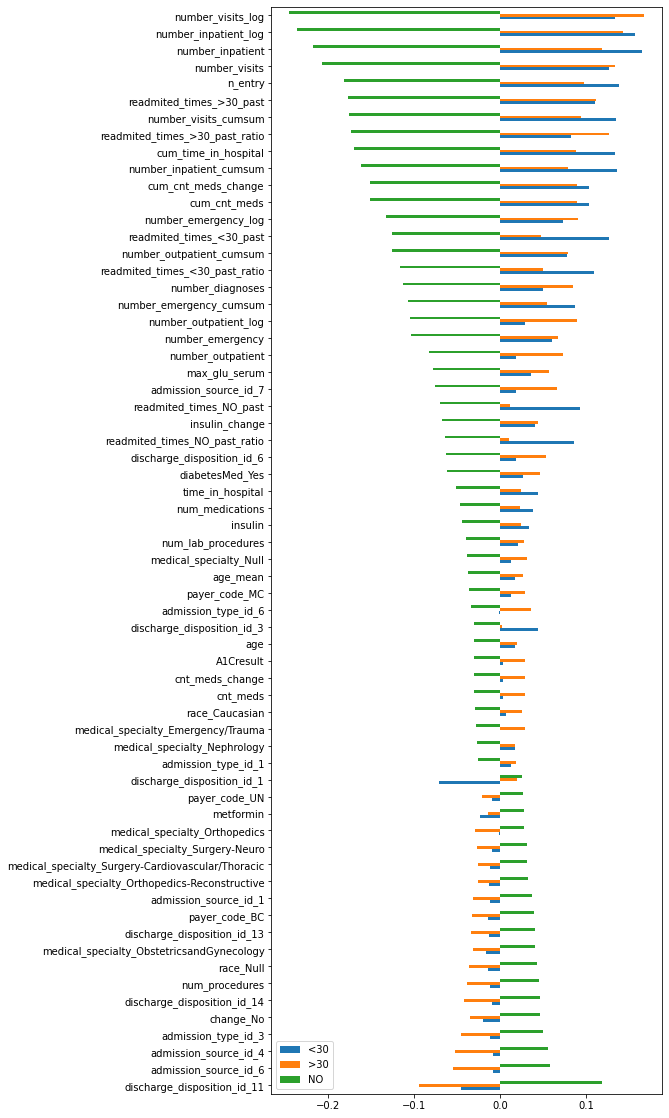

In [45]:
df_corr[~(df_corr[['<30', '>30', 'NO']]==1).any(axis=1)][df_corr['NO'].apply(np.abs)>0.025].plot(kind='barh', figsize=(7,20))

### Number of visits, a number of readmitted events, count of medicaments, total time in the hospital seems to be correlated with changes of being readmitted.
### And, for no readmitted cases, we have interesting variables as the deceased patients (discharge disposition 11) that have a low chance to be readmitted (very obvious) 

In [46]:
df_mvp_model['readmitted_label'] = LabelEncoder().fit_transform(df_mvp_model['readmitted'])

In [47]:
df_mvp_model['readmitted_label'].value_counts()

2    54861
1    35545
0    11357
Name: readmitted_label, dtype: int64

In [48]:
df_mvp_model.to_parquet('diabetic_data_mvp_model.parquet')
df_mvp_model.shape

(101763, 225)

In [49]:
ls -ltr -h

total 41M
-rw-rw-r-- 1 david david  19M may 15  2014 diabetic_data.csv
-rw-rw-r-- 1 david david 2,5K may 15  2014 IDs_mapping.csv
-rw-rw-r-- 1 david david 1,5M sep 21  2019 description.pdf
-rw-rw-r-- 1 david david  176 oct  3 18:36 README.md
-rw-rw-r-- 1 david david  13M oct  3 18:45 diabetic_report.html
-rw-rw-r-- 1 david david 4,3M oct  3 18:58 diabetic_processed.parquet
-rw-rw-r-- 1 david david 323K oct  3 19:25 David_Torres.ipynb
-rw-rw-r-- 1 david david 2,9M oct  3 19:25 diabetic_data_mvp_model.parquet


In [50]:
raise SystemExit("Stop right there!")

SystemExit: Stop right there!

/home/david/Escritorio/ds4a/py3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3425: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## Modeling MVP

In [51]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE

In [52]:
df_model = pd.read_parquet('diabetic_data_mvp_model.parquet').fillna(0)

In [53]:
df_model.shape

(101763, 225)

In [54]:
balanced = False

X_train, X_test, y_train, y_test = train_test_split(df_model.iloc[:,:-5], df_model.iloc[:,-2], test_size=0.10)

if ~balanced:
    X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.10)
else:
    smt = SMOTE()
    X_train_smote, y_train_smote = smt.fit_sample(X_train, y_train)
    X_train, X_dev, y_train, y_dev = train_test_split(X_train_smote, y_train_smote, test_size=0.10, random_state=0)

X_train.shape, X_test.shape, X_dev.shape

((82427, 220), (10177, 220), (9159, 220))

In [55]:
df_model.iloc[:,-5:]

,readmitted,<30,>30,NO,readmitted_label
8,NO,0,0,1,2
9,NO,0,0,1,2
4,NO,0,0,1,2
10,>30,0,1,0,1
5,>30,0,1,0,1
...,...,...,...,...,...
101761,>30,0,1,0,1
101762,NO,0,0,1,2
101763,NO,0,0,1,2
101764,NO,0,0,1,2


In [56]:
from sklearn.tree import DecisionTreeClassifier

In [79]:
model_DT = DecisionTreeClassifier(max_depth=25, criterion = "entropy", min_samples_split=15)

In [80]:
cv_score = cross_val_score(model_DT, X_train, y_train, cv=5)
cv_score.mean(), cv_score.std()

(0.5992089051505766, 0.00454494112840567)

In [81]:
model_DT.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=25, min_samples_split=15)

In [82]:
model_DT.score(X_dev, y_dev)

0.5996287804345453

In [83]:
y_dev_predict = model_DT.predict(X_dev)
print("Accuracy {0:.3f}".format(accuracy_score(y_dev, y_dev_predict)))
print("Precision {0:.3f}".format(precision_score(y_dev, y_dev_predict)))
print("Recall {0:.3f}".format(recall_score(y_dev, y_dev_predict)))
print("AUC {0:.3f}".format(roc_auc_score(y_dev, y_dev_predict)))

Accuracy 0.600
Precision 0.627
Recall 0.628
AUC 0.597


In [84]:
y_test_predict = model_DT.predict(X_test)
print("Accuracy {0:.3f}".format(accuracy_score(y_test, y_test_predict)))
print("Precision {0:.3f}".format(precision_score(y_test, y_test_predict)))
print("Recall {0:.3f}".format(recall_score(y_test, y_test_predict)))
print("AUC {0:.3f}".format(roc_auc_score(y_test, y_test_predict)))

Accuracy 0.598
Precision 0.626
Recall 0.638
AUC 0.595


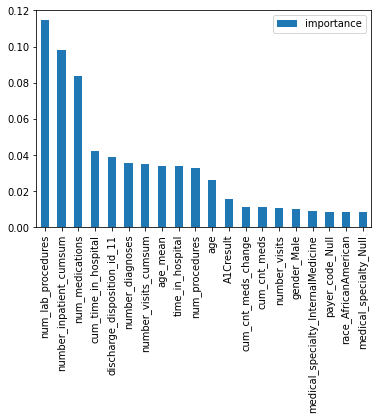

In [85]:
df_importance = pd.DataFrame(model_DT.feature_importances_,
                             index=X_train.columns,
                             columns=['importance']).sort_values('importance', ascending=False).head(20)
df_importance.plot(kind='bar')

In [86]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [87]:
rf_random = RandomForestClassifier()

In [ ]:
random_grid = {'bootstrap': [True, False],
 'max_depth': [100, 250],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [2, 4],
 'min_samples_split': [ 5, 10],
 'n_estimators': [250, 500]}

In [ ]:
rf_random = RandomizedSearchCV(estimator = rf,
                               param_distributions = random_grid,
                               n_iter = 150,
                               cv = 3,
                               verbose=2,
                               n_jobs = -1)

In [88]:
rf_random.fit(X_train, y_train)

RandomForestClassifier()

In [89]:
rf_random.best_estimator_

AttributeError: 'RandomForestClassifier' object has no attribute 'best_estimator_'

In [ ]:
import joblib
joblib.dump(rf_random, 'rf_random.pkl')

In [90]:
rf_random.score(X_dev, y_dev)

0.6462495905666558

In [91]:
y_dev_predict = rf_random.predict(X_dev)

In [92]:
print("Accuracy {0:.3f}".format(accuracy_score(y_dev, y_dev_predict)))
print("Precision {0:.3f}".format(precision_score(y_dev, y_dev_predict)))
print("Recall {0:.3f}".format(recall_score(y_dev, y_dev_predict)))
print("AUC {0:.3f}".format(roc_auc_score(y_dev, y_dev_predict)))

Accuracy 0.646
Precision 0.658
Recall 0.712
AUC 0.641


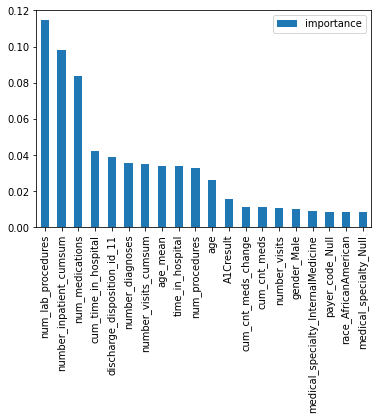

In [93]:
df_importance = pd.DataFrame(model_DT.feature_importances_,
                             index=X_train.columns,
                             columns=['importance']).sort_values('importance', ascending=False).head(20)
df_importance.plot(kind='bar')

In [119]:
from pycaret.classification import *

In [120]:
new_columns = []
for i in df_model.columns:
    new_columns = new_columns +[i.replace('<','less_').replace('>','greater_')]
df_model.columns = new_columns

In [121]:
#readmitted_label
clf1 = setup(data = df_model[df_model.columns[:-5].to_list() + ['readmitted_label']],
                  target = 'readmitted_label',
                  numeric_features=df_model.columns[:-5])

Setup Succesfully Completed!


,Description,Value
0,session_id,1721
1,Target Type,Multiclass
2,Label Encoded,"0: 0, 1: 1, 2: 2"
3,Original Data,"(101763, 221)"
4,Missing Values,False
5,Numeric Features,220
6,Categorical Features,0
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [126]:
lgbm = create_model('lightgbm')      

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.5969,0.0000,0.4275,0.5675,0.5535,0.2182,0.2336
1,0.6088,0.0000,0.4427,0.5914,0.5693,0.2462,0.2604
2,0.6028,0.0000,0.4301,0.5679,0.5587,0.2311,0.2464
3,0.5970,0.0000,0.4288,0.5686,0.5553,0.2218,0.2355
4,0.6102,0.0000,0.4423,0.5844,0.5696,0.2480,0.2634
5,0.6053,0.0000,0.4397,0.5838,0.5664,0.2407,0.2539
6,0.6064,0.0000,0.4427,0.5976,0.5667,0.2394,0.2548
7,0.6088,0.0000,0.4401,0.5817,0.5678,0.2449,0.2601
8,0.6103,0.0000,0.4412,0.5846,0.5693,0.2478,0.2631
9,0.6031,0.0000,0.4358,0.5796,0.5620,0.2331,0.2478


In [127]:
tuned_lightgbm = tune_model(lgbm)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.5990,0.0000,0.4299,0.5740,0.5560,0.2225,0.2380
1,0.6061,0.0000,0.4380,0.5868,0.5647,0.2384,0.2537
2,0.6002,0.0000,0.4280,0.5666,0.5559,0.2253,0.2406
3,0.6007,0.0000,0.4303,0.5669,0.5582,0.2286,0.2428
4,0.6142,0.0000,0.4440,0.5892,0.5727,0.2550,0.2709
5,0.6055,0.0000,0.4391,0.5822,0.5662,0.2406,0.2540
6,0.5995,0.0000,0.4336,0.5817,0.5580,0.2247,0.2399
7,0.6134,0.0000,0.4443,0.5921,0.5727,0.2540,0.2693
8,0.6115,0.0000,0.4413,0.5895,0.5692,0.2475,0.2643
9,0.6046,0.0000,0.4364,0.5805,0.5632,0.2355,0.2506


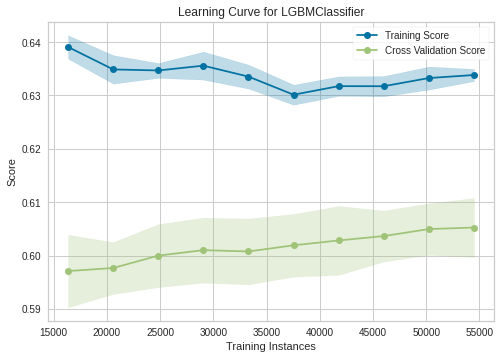

In [128]:
plot_model(estimator = tuned_lightgbm, plot = 'learning')

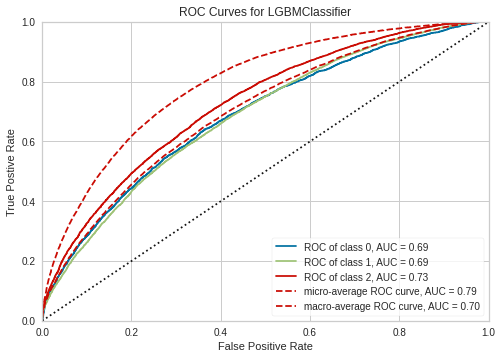

In [129]:
plot_model(estimator = tuned_lightgbm, plot = 'auc')

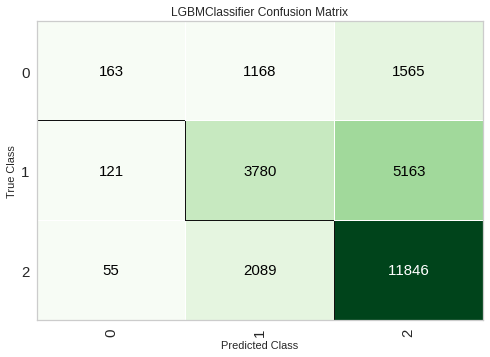

In [130]:
plot_model(estimator = tuned_lightgbm, plot = 'confusion_matrix')

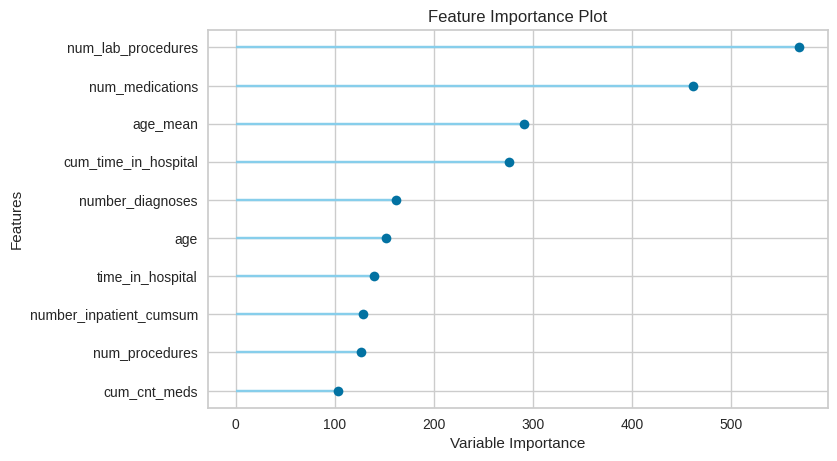

In [131]:
plot_model(estimator = tuned_lightgbm, plot = 'feature')

In [ ]:
interpret_model(tuned_lightgbm)

# Unsupervised

In [95]:
X = df_model.iloc[:,:-5]
Y = df_model.iloc[:,-1]

In [96]:
Y.value_counts()

2    54861
1    35545
0    11357
Name: readmitted_label, dtype: int64

In [97]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import time

In [98]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=300)
tsne_results = tsne.fit_transform(X)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 101763 samples in 18.282s...
[t-SNE] Computed neighbors for 101763 samples in 540.668s...
[t-SNE] Computed conditional probabilities for sample 1000 / 101763
[t-SNE] Computed conditional probabilities for sample 2000 / 101763
[t-SNE] Computed conditional probabilities for sample 3000 / 101763
[t-SNE] Computed conditional probabilities for sample 4000 / 101763
[t-SNE] Computed conditional probabilities for sample 5000 / 101763
[t-SNE] Computed conditional probabilities for sample 6000 / 101763
[t-SNE] Computed conditional probabilities for sample 7000 / 101763
[t-SNE] Computed conditional probabilities for sample 8000 / 101763
[t-SNE] Computed conditional probabilities for sample 9000 / 101763
[t-SNE] Computed conditional probabilities for sample 10000 / 101763
[t-SNE] Computed conditional probabilities for sample 11000 / 101763
[t-SNE] Computed conditional probabilities for sample 12000 / 101763
[t-SNE] Computed conditional pro

In [103]:
df_tsne = pd.DataFrame(tsne_results, columns=['x1','x2'], index=df_model.index)
df_tsne.to_parquet('tsne_results.parquet')

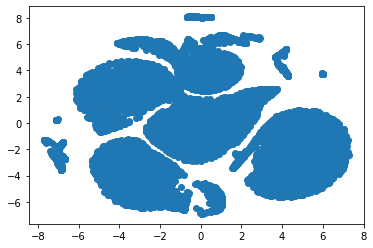

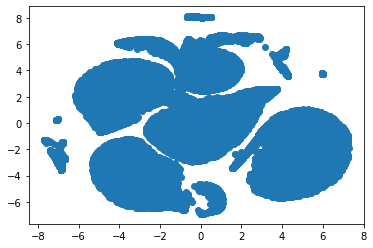

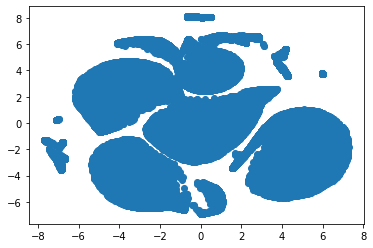

In [118]:
# create scatter plot for samples from each cluster
for cluster in range(3):
    # create scatter of these samples
    plt.figure()
    plt.scatter(df_tsne.loc[Y == cluster, 'x1'], df_tsne.loc[Y == cluster, 'x2'])
    # show the plot
    plt.show()

In [105]:
from sklearn.cluster import KMeans
# define the model
model = KMeans(n_clusters=3)
# fit the model
model.fit(X)
# assign a cluster to each example
yhat = model.predict(X)
# retrieve unique clusters
clusters = np.unique(yhat)

In [107]:
pd.DataFrame(yhat)[0].value_counts()

2    66632
0    32382
1     2749
Name: 0, dtype: int64

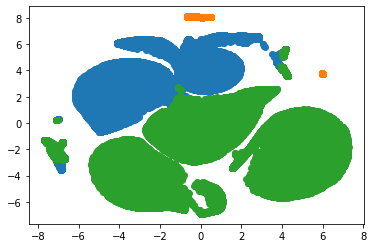

In [106]:
# create scatter plot for samples from each cluster
for cluster in clusters:
    # create scatter of these samples
    plt.scatter(df_tsne.loc[yhat == cluster, 'x1'], df_tsne.loc[yhat == cluster, 'x2'])
# show the plot
plt.show()

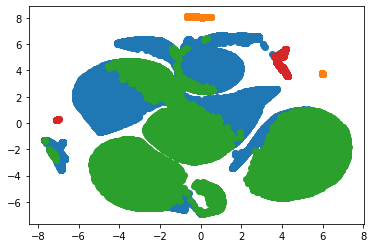

In [116]:
from sklearn.cluster import MiniBatchKMeans
# define the model
model = MiniBatchKMeans(n_clusters=4)
# fit the model
model.fit(X)
# assign a cluster to each example
yhat = model.predict(X)
# retrieve unique clusters
clusters = np.unique(yhat)
# create scatter plot for samples from each cluster
for cluster in clusters:
    # create scatter of these samples
    plt.scatter(df_tsne.loc[yhat == cluster, 'x1'], df_tsne.loc[yhat == cluster, 'x2'])
# show the plot
plt.show()

# NN

In [ ]:
df_model = pd.read_parquet('diabetic_processed.parquet')
df_model.shape


df_model = pd.concat([df_model,
                      pd.get_dummies(df_model['readmitted'])],
                     axis=1)

In [ ]:
df_model.describe().columns

In [ ]:
df_model.columns[~df_model.columns.isin(df_model.describe().columns)]

In [ ]:
ignore_features = ['encounter_id', 'patient_nbr','ones']

numeric_features=

categorical_features = 

target_feature=['readmitted']
len(ignore_features+numeric_features+categorical_features+target_feature)

In [ ]:
df_model = df_model[numeric_features+categorical_features+['readmitted']]
df_model.shape

In [ ]:
for i in tqdm(categorical_features):
    df_model[i] = LabelEncoder().fit_transform(df_model[i].fillna('Null'))

In [ ]:
df_model[['<30','>30','NO']] = pd.get_dummies(df_model['readmitted'])
df_model = df_model.drop(columns=['readmitted'])

In [ ]:
import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers
from tensorflow import keras
from sklearn.model_selection import train_test_split

In [ ]:
df_model[categorical_features].nunique()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_model.iloc[:,:-3], df_model.iloc[:,-3:], test_size=0.10)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10)

In [ ]:
X_train.shape, X_val.shape, X_test.shape, 

In [ ]:
# Numericals
num_variables = len(numeric_features)
X_train.columns[:num_variables]

In [ ]:
input_length = X_train.shape[1]
num_categorical = input_length-num_variables
num_categorical

In [ ]:
def max_cat(col_name):
    max_ = df_model[col_name].max()+1
    return int(max_), int(1.6*(max_**.56))

In [ ]:
cat_inputs = []
concat_emb_layer = []

num_input = keras.Input(shape=(1, num_variables), name='numeric')

num_layer = layers.Dense(64, 'relu', name='numeric_layer')(num_input)
num_layer = layers.Dropout(0.05)(num_layer)
num_layer = layers.Dense(32, 'relu', name='numeric_layer')(num_input)
num_layer = layers.Dropout(0.05)(num_layer)

for i in range(len(categorical_features)):
    _input = keras.Input(shape=(1,), name='cat_'+categorical_features[i])
    _embed = layers.Embedding(max_cat(categorical_features[i])[0], max_cat(categorical_features[i])[1],
                              name='emb_'+categorical_features[i])(_input)
    print(categorical_features[i], max_cat(categorical_features[i]))

    cat_inputs.append(_input)
    concat_emb_layer.append(_embed)


emb_layer = layers.concatenate(concat_emb_layer)
emb_layer = layers.Dropout(0.5)(emb_layer)

emb_layer = layers.Dense(64, activation='linear')(emb_layer)
emb_layer = layers.Dropout(0.5)(emb_layer)
emb_layer = layers.Dense(32, activation='relu')(emb_layer)
emb_layer = layers.Dropout(0.25)(emb_layer)
emb_layer = layers.Dense(16, activation='relu')(emb_layer)
emb_layer = layers.Dropout(0.25)(emb_layer)

x = layers.concatenate([num_layer, emb_layer])
x = layers.Dense(32, 'relu', name='layer_1')(x)
x = layers.Dropout(0.15)(x)
x = layers.Dense(16, 'relu', name='layer_2')(x)
x = layers.Dropout(0.25)(x)

output = layers.Dense(3, activation='softmax', name='predict')(x)

In [ ]:
model = keras.Model([num_input]+cat_inputs, output)

In [ ]:
keras.utils.plot_model(model, show_shapes=False, rankdir="LR")

In [ ]:
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.CategoricalAccuracy()])
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
#model.optimizer.lr = 0.1

In [ ]:
def format_dataset(df):
    X = [df.iloc[:,:num_variables].fillna(0).astype('float32').values.reshape(-1,1,num_variables)]
    for i in categorical_features:
        X.append(df[i].astype('float32').values)
    return X

In [ ]:
history = model.fit(format_dataset(X_train), y_train.values.reshape(-1,1,3),
    validation_data=(format_dataset(X_val), y_val.values.reshape(-1,1,3)),
                    batch_size=64,
                    epochs=100)

In [ ]:
 model.evaluate(format_dataset(X_train), y_train.values.reshape(-1,1,3))

In [ ]:
print("Evaluate on test data")
results = model.evaluate(format_dataset(X_test), y_test.values.reshape(-1,1,3))
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 3 samples")
predictions = model.predict(format_dataset(X_test[:3]))
print("predictions shape:", predictions.shape)

In [ ]:
model.predict(format_dataset(X_test[100,:,:])), y_test[100,:]

In [ ]:
y_pred = model.predict(format_dataset(X_test)).reshape(X_test.shape[0],3)
y_pred[:,0]

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.plot(y_pred[:,0])